
# HW6 Diffusion Model

**Sources:**
- Github implementation [Denoising Diffusion Pytorch](https://github.com/lucidrains/denoising-diffusion-pytorch)
- Papers on Diffusion models ([Dhariwal, Nichol, 2021], [Ho et al., 2020] ect.)


| Baseline        | Suggestion                       | Estimated time |

| Simple baseline | Just Run Sample Code             | 1hr            |

| Medium baseline | data augmentation, More Timestep | 3hr            |

| Strong baseline | Model Arch, Variance Scheduler   | 6hr            |

| Boss baseline   | styleGAN                         | 8hr            |

可能做法：更多timestep、兩次diffusion

In [1]:
!nvidia-smi

Sun Apr 23 05:58:29 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.161.03   Driver Version: 470.161.03   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Import Packages and Set Seeds

In [2]:
!pip install einops
!pip install transformers
!pip install ema_pytorch
!pip install accelerate
# !pip install pytorch-fid

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 2.0 MB/s eta 0:00:00


In [3]:
import math
import copy
from pathlib import Path
from random import random
from functools import partial
from collections import namedtuple
from multiprocessing import cpu_count

import torch
from torch import nn, einsum
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from torch.optim import Adam

import torchvision
from torchvision import transforms as T, utils

from einops import rearrange, reduce, repeat
from einops.layers.torch import Rearrange

from PIL import Image
from tqdm.auto import tqdm
from ema_pytorch import EMA

from accelerate import Accelerator

# from pytorch_fid.inception import InceptionV3
# from pytorch_fid.fid_score import calculate_frechet_distance

import matplotlib.pyplot as plt
import os

torch.backends.cudnn.benchmark = True
torch.manual_seed(4096)

if torch.cuda.is_available():
    torch.cuda.manual_seed(4096)

## Step 1: Forward process (Noise scheduler)




Create dataset

In [4]:
class Dataset(Dataset):
    def __init__(
        self,
        folder,
        image_size
    ):
        self.folder = folder
        self.image_size = image_size
        self.paths = [p for p in Path(f'{folder}').glob(f'**/*.jpg')]
        #################################
        ## TODO: Data Augmentation ##
        #################################
        self.transform = T.Compose([
            T.Resize(image_size),
            T.RandomHorizontalFlip(),
#             T.RandomRotation(15),
            T.ToTensor()
        ])

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, index):
        path = self.paths[index]
        img = Image.open(path)
        return self.transform(img)

data: 71314


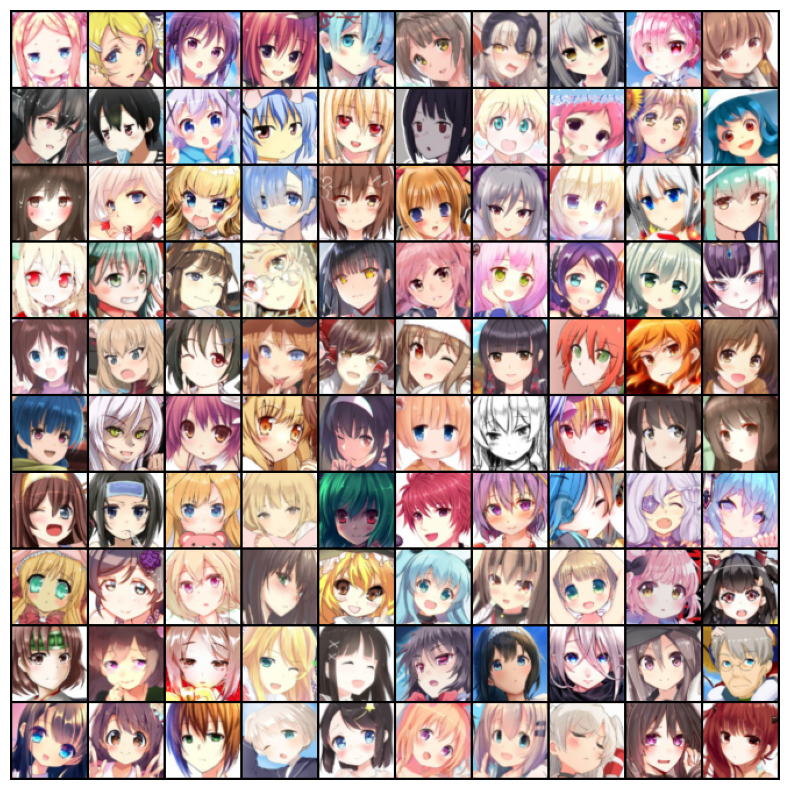

2032

In [5]:
temp_dataset = Dataset("/kaggle/input/diffusion/faces", 64)
print("data:", len(temp_dataset));
images = [temp_dataset[i] for i in range(10*10)]
grid_img = torchvision.utils.make_grid(images, ncol=10, nrow=10)
plt.figure(figsize=(10,10))
plt.imshow(grid_img.permute(1, 2, 0))
plt.axis('off')
plt.show()

del temp_dataset
import gc
gc.collect()

## Step 2: The backward process = U-Net



Define some useful functions and U-Net

In [6]:
# helpers functions

def exists(x):
    return x is not None

def default(val, d):
    if exists(val):
        return val
    return d() if callable(d) else d

def identity(t, *args, **kwargs):
    return t

def cycle(dl):
    while True:
        for data in dl:
            yield data

def has_int_squareroot(num):
    return (math.sqrt(num) ** 2) == num

def num_to_groups(num, divisor):
    groups = num // divisor
    remainder = num % divisor
    arr = [divisor] * groups
    if remainder > 0:
        arr.append(remainder)
    return arr

# normalization functions

def normalize_to_neg_one_to_one(img):
    return img * 2 - 1

def unnormalize_to_zero_to_one(t):
    return (t + 1) * 0.5

# small helper modules

class Residual(nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn

    def forward(self, x, *args, **kwargs):
        return self.fn(x, *args, **kwargs) + x

def Upsample(dim, dim_out = None):
    return nn.Sequential(
        nn.Upsample(scale_factor = 2, mode = 'nearest'),
        nn.Conv2d(dim, default(dim_out, dim), 3, padding = 1)
    )

def Downsample(dim, dim_out = None):
    return nn.Sequential(
        Rearrange('b c (h p1) (w p2) -> b (c p1 p2) h w', p1 = 2, p2 = 2),
        nn.Conv2d(dim * 4, default(dim_out, dim), 1)
    )

class WeightStandardizedConv2d(nn.Conv2d):
    """
    https://arxiv.org/abs/1903.10520
    weight standardization purportedly works synergistically with group normalization
    """
    def forward(self, x):
        eps = 1e-5 if x.dtype == torch.float32 else 1e-3

        weight = self.weight
        mean = reduce(weight, 'o ... -> o 1 1 1', 'mean')
        var = reduce(weight, 'o ... -> o 1 1 1', partial(torch.var, unbiased = False))
        normalized_weight = (weight - mean) * (var + eps).rsqrt()

        return F.conv2d(x, normalized_weight, self.bias, self.stride, self.padding, self.dilation, self.groups)

class LayerNorm(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.g = nn.Parameter(torch.ones(1, dim, 1, 1))

    def forward(self, x):
        eps = 1e-5 if x.dtype == torch.float32 else 1e-3
        var = torch.var(x, dim = 1, unbiased = False, keepdim = True)
        mean = torch.mean(x, dim = 1, keepdim = True)
        return (x - mean) * (var + eps).rsqrt() * self.g

class PreNorm(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.fn = fn
        self.norm = LayerNorm(dim)

    def forward(self, x):
        x = self.norm(x)
        return self.fn(x)

# sinusoidal positional embeds

class SinusoidalPosEmb(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, x):
        device = x.device
        half_dim = self.dim // 2
        emb = math.log(10000) / (half_dim - 1)
        emb = torch.exp(torch.arange(half_dim, device=device) * -emb)
        emb = x[:, None] * emb[None, :]
        emb = torch.cat((emb.sin(), emb.cos()), dim=-1)
        return emb

class RandomOrLearnedSinusoidalPosEmb(nn.Module):
    """ following @crowsonkb 's lead with random (learned optional) sinusoidal pos emb """
    """ https://github.com/crowsonkb/v-diffusion-jax/blob/master/diffusion/models/danbooru_128.py#L8 """

    def __init__(self, dim, is_random = False):
        super().__init__()
        assert (dim % 2) == 0
        half_dim = dim // 2
        self.weights = nn.Parameter(torch.randn(half_dim), requires_grad = not is_random)

    def forward(self, x):
        x = rearrange(x, 'b -> b 1')
        freqs = x * rearrange(self.weights, 'd -> 1 d') * 2 * math.pi
        fouriered = torch.cat((freqs.sin(), freqs.cos()), dim = -1)
        fouriered = torch.cat((x, fouriered), dim = -1)
        return fouriered

# building block modules

class Block(nn.Module):
    def __init__(self, dim, dim_out, groups = 8):
        super().__init__()
        self.proj = WeightStandardizedConv2d(dim, dim_out, 3, padding = 1)
        self.norm = nn.GroupNorm(groups, dim_out)
        self.act = nn.SiLU()

    def forward(self, x, scale_shift = None):
        x = self.proj(x)
        x = self.norm(x)

        if exists(scale_shift):
            scale, shift = scale_shift
            x = x * (scale + 1) + shift

        x = self.act(x)
        return x

class ResnetBlock(nn.Module):
    def __init__(self, dim, dim_out, *, time_emb_dim = None, groups = 8):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.SiLU(),
            nn.Linear(time_emb_dim, dim_out * 2)
        ) if exists(time_emb_dim) else None

        self.block1 = Block(dim, dim_out, groups = groups)
        self.block2 = Block(dim_out, dim_out, groups = groups)
        self.res_conv = nn.Conv2d(dim, dim_out, 1) if dim != dim_out else nn.Identity()

    def forward(self, x, time_emb = None):

        scale_shift = None
        if exists(self.mlp) and exists(time_emb):
            time_emb = self.mlp(time_emb)
            time_emb = rearrange(time_emb, 'b c -> b c 1 1')
            scale_shift = time_emb.chunk(2, dim = 1)

        h = self.block1(x, scale_shift = scale_shift)

        h = self.block2(h)

        return h + self.res_conv(x)

class LinearAttention(nn.Module):
    def __init__(self, dim, heads = 4, dim_head = 32):
        super().__init__()
        self.scale = dim_head ** -0.5
        self.heads = heads
        hidden_dim = dim_head * heads
        self.to_qkv = nn.Conv2d(dim, hidden_dim * 3, 1, bias = False)

        self.to_out = nn.Sequential(
            nn.Conv2d(hidden_dim, dim, 1),
            LayerNorm(dim)
        )

    def forward(self, x):
        b, c, h, w = x.shape
        qkv = self.to_qkv(x).chunk(3, dim = 1)
        q, k, v = map(lambda t: rearrange(t, 'b (h c) x y -> b h c (x y)', h = self.heads), qkv)

        q = q.softmax(dim = -2)
        k = k.softmax(dim = -1)

        q = q * self.scale
        v = v / (h * w)

        context = torch.einsum('b h d n, b h e n -> b h d e', k, v)

        out = torch.einsum('b h d e, b h d n -> b h e n', context, q)
        out = rearrange(out, 'b h c (x y) -> b (h c) x y', h = self.heads, x = h, y = w)
        return self.to_out(out)

class Attention(nn.Module):
    def __init__(self, dim, heads = 4, dim_head = 32):
        super().__init__()
        self.scale = dim_head ** -0.5
        self.heads = heads
        hidden_dim = dim_head * heads

        self.to_qkv = nn.Conv2d(dim, hidden_dim * 3, 1, bias = False)
        self.to_out = nn.Conv2d(hidden_dim, dim, 1)

    def forward(self, x):
        b, c, h, w = x.shape
        qkv = self.to_qkv(x).chunk(3, dim = 1)
        q, k, v = map(lambda t: rearrange(t, 'b (h c) x y -> b h c (x y)', h = self.heads), qkv)

        q = q * self.scale

        sim = torch.einsum('b h d i, b h d j -> b h i j', q, k)
        attn = sim.softmax(dim = -1)
        out = torch.einsum('b h i j, b h d j -> b h i d', attn, v)

        out = rearrange(out, 'b h (x y) d -> b (h d) x y', x = h, y = w)
        return self.to_out(out)

# model

class Unet(nn.Module):
    def __init__(
        self,
        dim,
        init_dim = None,
        out_dim = None,
        dim_mults=(1, 2, 4, 8),
        channels = 3,
        resnet_block_groups = 8,
        learned_sinusoidal_cond = False,
        random_fourier_features = False,
        learned_sinusoidal_dim = 16
    ):
        super().__init__()

        # determine dimensions

        self.channels = channels

        init_dim = default(init_dim, dim)
        self.init_conv = nn.Conv2d(channels, init_dim, 7, padding = 3)

        dims = [init_dim, *map(lambda m: dim * m, dim_mults)]
        in_out = list(zip(dims[:-1], dims[1:]))

        block_klass = partial(ResnetBlock, groups = resnet_block_groups)

        # time embeddings

        time_dim = dim * 4

        self.random_or_learned_sinusoidal_cond = learned_sinusoidal_cond or random_fourier_features

        if self.random_or_learned_sinusoidal_cond:
            sinu_pos_emb = RandomOrLearnedSinusoidalPosEmb(learned_sinusoidal_dim, random_fourier_features)
            fourier_dim = learned_sinusoidal_dim + 1
        else:
            sinu_pos_emb = SinusoidalPosEmb(dim)
            fourier_dim = dim

        self.time_mlp = nn.Sequential(
            sinu_pos_emb,
            nn.Linear(fourier_dim, time_dim),
            nn.GELU(),
            nn.Linear(time_dim, time_dim)
        )

        # layers

        self.downs = nn.ModuleList([])
        self.ups = nn.ModuleList([])
        num_resolutions = len(in_out)

        for ind, (dim_in, dim_out) in enumerate(in_out):
            is_last = ind >= (num_resolutions - 1)

            self.downs.append(nn.ModuleList([
                block_klass(dim_in, dim_in, time_emb_dim = time_dim),
                block_klass(dim_in, dim_in, time_emb_dim = time_dim),
                Residual(PreNorm(dim_in, LinearAttention(dim_in))),
                Downsample(dim_in, dim_out) if not is_last else nn.Conv2d(dim_in, dim_out, 3, padding = 1)
            ]))

        mid_dim = dims[-1]
        self.mid_block1 = block_klass(mid_dim, mid_dim, time_emb_dim = time_dim)
        self.mid_attn = Residual(PreNorm(mid_dim, Attention(mid_dim)))
        self.mid_block2 = block_klass(mid_dim, mid_dim, time_emb_dim = time_dim)

        for ind, (dim_in, dim_out) in enumerate(reversed(in_out)):
            is_last = ind == (len(in_out) - 1)

            self.ups.append(nn.ModuleList([
                block_klass(dim_out + dim_in, dim_out, time_emb_dim = time_dim),
                block_klass(dim_out + dim_in, dim_out, time_emb_dim = time_dim),
                Residual(PreNorm(dim_out, LinearAttention(dim_out))),
                Upsample(dim_out, dim_in) if not is_last else  nn.Conv2d(dim_out, dim_in, 3, padding = 1)
            ]))

        self.out_dim = default(out_dim, channels)

        self.final_res_block = block_klass(dim * 2, dim, time_emb_dim = time_dim)
        self.final_conv = nn.Conv2d(dim, self.out_dim, 1)

    def forward(self, x, time):
        x = self.init_conv(x)
        r = x.clone()

        t = self.time_mlp(time)

        h = []

        for block1, block2, attn, downsample in self.downs:
            x = block1(x, t)
            h.append(x)

            x = block2(x, t)
            x = attn(x)
            h.append(x)

            x = downsample(x)

        x = self.mid_block1(x, t)
        x = self.mid_attn(x)
        x = self.mid_block2(x, t)

        for block1, block2, attn, upsample in self.ups:
            x = torch.cat((x, h.pop()), dim = 1)
            x = block1(x, t)

            x = torch.cat((x, h.pop()), dim = 1)
            x = block2(x, t)
            x = attn(x)

            x = upsample(x)

        x = torch.cat((x, r), dim = 1)

        x = self.final_res_block(x, t)
        return self.final_conv(x)

## Step 3: The Diffusion Process



Define diffusion process, including generating noisy models, sample...


In [7]:
def extract(a, t, x_shape):
    b, *_ = t.shape
    out = a.gather(-1, t)
    return out.reshape(b, *((1,) * (len(x_shape) - 1)))

def linear_beta_schedule(timesteps):
    """
    linear schedule, proposed in original ddpm paper
    """
    scale = 1000 / timesteps
    beta_start = scale * 0.0001
    beta_end = scale * 0.02
    return torch.linspace(beta_start, beta_end, timesteps, dtype = torch.float64)

def cosine_beta_schedule(timesteps, s = 0.008):
    """
    cosine schedule
    as proposed in https://openreview.net/forum?id=-NEXDKk8gZ
    """
    steps = timesteps + 1
    t = torch.linspace(0, timesteps, steps, dtype = torch.float64) / timesteps
    alphas_cumprod = torch.cos((t + s) / (1 + s) * math.pi * 0.5) ** 2
    alphas_cumprod = alphas_cumprod / alphas_cumprod[0]
    betas = 1 - (alphas_cumprod[1:] / alphas_cumprod[:-1])
    return torch.clip(betas, 0, 0.999)

def sigmoid_beta_schedule(timesteps, start = -3, end = 3, tau = 1, clamp_min = 1e-5):
    """
    sigmoid schedule
    proposed in https://arxiv.org/abs/2212.11972 - Figure 8
    better for images > 64x64, when used during training
    """
    steps = timesteps + 1
    t = torch.linspace(0, timesteps, steps, dtype = torch.float64) / timesteps
    v_start = torch.tensor(start / tau).sigmoid()
    v_end = torch.tensor(end / tau).sigmoid()
    alphas_cumprod = (-((t * (end - start) + start) / tau).sigmoid() + v_end) / (v_end - v_start)
    alphas_cumprod = alphas_cumprod / alphas_cumprod[0]
    betas = 1 - (alphas_cumprod[1:] / alphas_cumprod[:-1])
    return torch.clip(betas, 0, 0.999)

In [8]:
class GaussianDiffusion(nn.Module):
    def __init__(
        self,
        model,
        *,
        image_size,
        timesteps = 1000,
        loss_type = 'l1',
        beta_schedule = 'sigmoid',
        schedule_fn_kwargs = dict(),
        auto_normalize = True
    ):
        super().__init__()
        assert not (type(self) == GaussianDiffusion and model.channels != model.out_dim)
        assert not model.random_or_learned_sinusoidal_cond

        self.model = model

        self.channels = self.model.channels

        self.image_size = image_size


        if beta_schedule == 'linear':
            beta_schedule_fn = linear_beta_schedule
        elif beta_schedule == 'cosine':
            beta_schedule_fn = cosine_beta_schedule
        elif beta_schedule == 'sigmoid':
            beta_schedule_fn = sigmoid_beta_schedule
        else:
            raise ValueError(f'unknown beta schedule {beta_schedule}')
        
        # calculate beta and other precalculated parameters
        betas = beta_schedule_fn(timesteps, **schedule_fn_kwargs)
                                            
        alphas = 1. - betas
        alphas_cumprod = torch.cumprod(alphas, dim=0)
        alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value = 1.)

        timesteps, = betas.shape
        self.num_timesteps = int(timesteps)
        self.loss_type = loss_type

        # sampling related parameters

        self.sampling_timesteps = timesteps # default num sampling timesteps to number of timesteps at training

        # helper function to register buffer from float64 to float32

        register_buffer = lambda name, val: self.register_buffer(name, val.to(torch.float32))

        register_buffer('betas', betas)
        register_buffer('alphas_cumprod', alphas_cumprod)
        register_buffer('alphas_cumprod_prev', alphas_cumprod_prev)

        # calculations for diffusion q(x_t | x_{t-1}) and others

        register_buffer('sqrt_alphas_cumprod', torch.sqrt(alphas_cumprod))
        register_buffer('sqrt_one_minus_alphas_cumprod', torch.sqrt(1. - alphas_cumprod))
        register_buffer('log_one_minus_alphas_cumprod', torch.log(1. - alphas_cumprod))
        register_buffer('sqrt_recip_alphas_cumprod', torch.sqrt(1. / alphas_cumprod))
        register_buffer('sqrt_recipm1_alphas_cumprod', torch.sqrt(1. / alphas_cumprod - 1))

        # calculations for posterior q(x_{t-1} | x_t, x_0)

        posterior_variance = betas * (1. - alphas_cumprod_prev) / (1. - alphas_cumprod)

        # above: equal to 1. / (1. / (1. - alpha_cumprod_tm1) + alpha_t / beta_t)

        register_buffer('posterior_variance', posterior_variance)

        # below: log calculation clipped because the posterior variance is 0 at the beginning of the diffusion chain

        register_buffer('posterior_log_variance_clipped', torch.log(posterior_variance.clamp(min =1e-20)))
        register_buffer('posterior_mean_coef1', betas * torch.sqrt(alphas_cumprod_prev) / (1. - alphas_cumprod))
        register_buffer('posterior_mean_coef2', (1. - alphas_cumprod_prev) * torch.sqrt(alphas) / (1. - alphas_cumprod))

        # derive loss weight
        # snr - signal noise ratio

        snr = alphas_cumprod / (1 - alphas_cumprod)

        # https://arxiv.org/abs/2303.09556

        maybe_clipped_snr = snr.clone()

        register_buffer('loss_weight', maybe_clipped_snr / snr)

        # auto-normalization of data [0, 1] -> [-1, 1] - can turn off by setting it to be False

        self.normalize = normalize_to_neg_one_to_one if auto_normalize else identity
        self.unnormalize = unnormalize_to_zero_to_one if auto_normalize else identity

    def predict_start_from_noise(self, x_t, t, noise):
        return (
            extract(self.sqrt_recip_alphas_cumprod, t, x_t.shape) * x_t -
            extract(self.sqrt_recipm1_alphas_cumprod, t, x_t.shape) * noise
        )

    def predict_noise_from_start(self, x_t, t, x0):
        return (
            (extract(self.sqrt_recip_alphas_cumprod, t, x_t.shape) * x_t - x0) / \
            extract(self.sqrt_recipm1_alphas_cumprod, t, x_t.shape)
        )


    def q_posterior(self, x_start, x_t, t):
        posterior_mean = (
            extract(self.posterior_mean_coef1, t, x_t.shape) * x_start +
            extract(self.posterior_mean_coef2, t, x_t.shape) * x_t
        )
        posterior_variance = extract(self.posterior_variance, t, x_t.shape)
        posterior_log_variance_clipped = extract(self.posterior_log_variance_clipped, t, x_t.shape)
        return posterior_mean, posterior_variance, posterior_log_variance_clipped

    def model_predictions(self, x, t, clip_x_start = False, rederive_pred_noise = False):
        model_output = self.model(x, t)
        maybe_clip = partial(torch.clamp, min = -1., max = 1.) if clip_x_start else identity

        pred_noise = model_output
        x_start = self.predict_start_from_noise(x, t, pred_noise)
        x_start = maybe_clip(x_start)

        if clip_x_start and rederive_pred_noise:
            pred_noise = self.predict_noise_from_start(x, t, x_start)

        return pred_noise, x_start

    def p_mean_variance(self, x, t, clip_denoised = True):
        noise, x_start = self.model_predictions(x, t)

        if clip_denoised:
            x_start.clamp_(-1., 1.)

        model_mean, posterior_variance, posterior_log_variance = self.q_posterior(x_start = x_start, x_t = x, t = t)
        return model_mean, posterior_variance, posterior_log_variance, x_start

    @torch.no_grad()
    def p_sample(self, x, t: int):
        b, *_, device = *x.shape, x.device
        batched_times = torch.full((b,), t, device = x.device, dtype = torch.long)
        model_mean, _, model_log_variance, x_start = self.p_mean_variance(x = x, t = batched_times, clip_denoised = True)
        noise = torch.randn_like(x) if t > 0 else 0. # no noise if t == 0
        pred_img = model_mean + (0.5 * model_log_variance).exp() * noise
        return pred_img, x_start

    @torch.no_grad()
    def p_sample_loop(self, shape, return_all_timesteps = False):
        batch, device = shape[0], self.betas.device

        img = torch.randn(shape, device = device)
        imgs = [img]

        x_start = None
        
        ###########################################
        ## TODO: plot the sampling process ##
        ###########################################
        for t in tqdm(reversed(range(0, self.num_timesteps)), desc = 'sampling loop time step', total = self.num_timesteps):
            img, x_start = self.p_sample(img, t)
            imgs.append(img)
        
        ret = img if not return_all_timesteps else torch.stack(imgs, dim = 1)

        ret = self.unnormalize(ret)
        return ret

    @torch.no_grad()
    def sample(self, batch_size = 16, return_all_timesteps = False):
        image_size, channels = self.image_size, self.channels
        sample_fn = self.p_sample_loop
        return sample_fn((batch_size, channels, image_size, image_size), return_all_timesteps = return_all_timesteps)


    def q_sample(self, x_start, t, noise=None):
        noise = default(noise, lambda: torch.randn_like(x_start))

        return (
            extract(self.sqrt_alphas_cumprod, t, x_start.shape) * x_start +
            extract(self.sqrt_one_minus_alphas_cumprod, t, x_start.shape) * noise
        )

    @property
    def loss_fn(self):
        if self.loss_type == 'l1':
            return F.l1_loss
        elif self.loss_type == 'l2':
            return F.mse_loss
        else:
            raise ValueError(f'invalid loss type {self.loss_type}')


    def p_losses(self, x_start, t, noise = None):
        b, c, h, w = x_start.shape
        noise = default(noise, lambda: torch.randn_like(x_start))

        # noise sample

        x = self.q_sample(x_start = x_start, t = t, noise = noise)

        # predict and take gradient step

        model_out = self.model(x, t)

        loss = self.loss_fn(model_out, noise, reduction = 'none')
        loss = reduce(loss, 'b ... -> b (...)', 'mean')

        loss = loss * extract(self.loss_weight, t, loss.shape)
        return loss.mean()

    def forward(self, img, *args, **kwargs):
        b, c, h, w, device, img_size, = *img.shape, img.device, self.image_size
        assert h == img_size and w == img_size, f'height and width of image must be {img_size}'
        t = torch.randint(0, self.num_timesteps, (b,), device=device).long()

        img = self.normalize(img)
        return self.p_losses(img, t, *args, **kwargs)


Define Trainer: define the updating process

In [9]:
class Trainer(object):
    def __init__(
        self,
        diffusion_model,
        folder,
        *,
        train_batch_size = 16,
        gradient_accumulate_every = 1,
        train_lr = 1e-4,
        train_num_steps = 100000,
        ema_update_every = 10,
        ema_decay = 0.995,
        adam_betas = (0.9, 0.99),
        save_and_sample_every = 1000,
        num_samples = 25,
        results_folder = './results',
        split_batches = True,
#         calculate_fid = True,
        inception_block_idx = 2048
    ):
        super().__init__()

        # accelerator

        self.accelerator = Accelerator(
            split_batches = split_batches,
            mixed_precision = 'no'
        )

        # model

        self.model = diffusion_model
        self.channels = diffusion_model.channels

#         # InceptionV3 for fid-score computation

#         self.inception_v3 = None

#         if calculate_fid:
#             assert inception_block_idx in InceptionV3.BLOCK_INDEX_BY_DIM
#             block_idx = InceptionV3.BLOCK_INDEX_BY_DIM[inception_block_idx]
#             self.inception_v3 = InceptionV3([block_idx])
#             self.inception_v3.to(self.device)
        
        # sampling and training hyperparameters

        assert has_int_squareroot(num_samples), 'number of samples must have an integer square root'
        self.num_samples = num_samples
        self.save_and_sample_every = save_and_sample_every

        self.batch_size = train_batch_size
        self.gradient_accumulate_every = gradient_accumulate_every

        self.train_num_steps = train_num_steps
        self.image_size = diffusion_model.image_size

        # dataset and dataloader

        self.ds = Dataset(folder, self.image_size)
        dl = DataLoader(self.ds, batch_size = train_batch_size, shuffle = True, pin_memory = True, num_workers = cpu_count())

        dl = self.accelerator.prepare(dl)
        self.dl = cycle(dl)

        # optimizer

        self.opt = Adam(diffusion_model.parameters(), lr = train_lr, betas = adam_betas)

        # for logging results in a folder periodically

        if self.accelerator.is_main_process:
            self.ema = EMA(diffusion_model, beta = ema_decay, update_every = ema_update_every)
            self.ema.to(self.device)

        self.results_folder = Path(results_folder)
        self.results_folder.mkdir(exist_ok = True)

        # step counter state

        self.step = 0

        # prepare model, dataloader, optimizer with accelerator

        self.model, self.opt = self.accelerator.prepare(self.model, self.opt)

    @property
    def device(self):
        return self.accelerator.device

    def save(self, milestone):
        if not self.accelerator.is_local_main_process:
            return

        data = {
            'step': self.step,
            'model': self.accelerator.get_state_dict(self.model),
            'opt': self.opt.state_dict(),
            'ema': self.ema.state_dict(),
            'scaler': self.accelerator.scaler.state_dict() if exists(self.accelerator.scaler) else None,
        }

        torch.save(data, str(self.results_folder / f'model-{milestone:03d}.pt'))

    def load(self, ckpt):
        accelerator = self.accelerator
        device = accelerator.device

        data = torch.load(ckpt, map_location=device)

        model = self.accelerator.unwrap_model(self.model)
        model.load_state_dict(data['model'])

        self.step = data['step']
        self.opt.load_state_dict(data['opt'])
        if self.accelerator.is_main_process:
            self.ema.load_state_dict(data["ema"])


        if exists(self.accelerator.scaler) and exists(data['scaler']):
            self.accelerator.scaler.load_state_dict(data['scaler'])

#     @torch.no_grad()
#     def calculate_activation_statistics(self, samples):
#         assert exists(self.inception_v3)

#         features = self.inception_v3(samples)[0]
#         features = rearrange(features, '... 1 1 -> ...')

#         mu = torch.mean(features, dim = 0).cpu()
#         sigma = torch.cov(features).cpu()
#         return mu, sigma

#     def fid_score(self, real_samples, fake_samples):

#         if self.channels == 1:
#             real_samples, fake_samples = map(lambda t: repeat(t, 'b 1 ... -> b c ...', c = 3), (real_samples, fake_samples))

#         min_batch = min(real_samples.shape[0], fake_samples.shape[0])
#         real_samples, fake_samples = map(lambda t: t[:min_batch], (real_samples, fake_samples))

#         m1, s1 = self.calculate_activation_statistics(real_samples)
#         m2, s2 = self.calculate_activation_statistics(fake_samples)

#         fid_value = calculate_frechet_distance(m1, s1, m2, s2)
#         return fid_value

    def train(self):
        accelerator = self.accelerator
        device = accelerator.device

        with tqdm(initial = self.step, total = self.train_num_steps, disable = not accelerator.is_main_process) as pbar:

            while self.step < self.train_num_steps:

                total_loss = 0.

                for _ in range(self.gradient_accumulate_every):
                    data = next(self.dl).to(device)

                    with self.accelerator.autocast():
                        loss = self.model(data)
                        loss = loss / self.gradient_accumulate_every
                        total_loss += loss.item()

                    self.accelerator.backward(loss)

                accelerator.clip_grad_norm_(self.model.parameters(), 1.0)
                pbar.set_description(f'loss: {total_loss:.4f}')

                accelerator.wait_for_everyone()

                self.opt.step()
                self.opt.zero_grad()

                accelerator.wait_for_everyone()

                self.step += 1
                if accelerator.is_main_process:
                    self.ema.update()

                    if self.step != 0 and self.step % self.save_and_sample_every == 0:
                        self.ema.ema_model.eval()

                        with torch.no_grad():
                            milestone = self.step // self.save_and_sample_every
                            batches = num_to_groups(self.num_samples, self.batch_size)
                            all_images_list = list(map(lambda n: self.ema.ema_model.sample(batch_size=n), batches))

                        all_images = torch.cat(all_images_list, dim = 0)

                        utils.save_image(all_images, str(self.results_folder / f'sample-{milestone:03d}.png'), nrow = int(math.sqrt(self.num_samples)))
                        
                        self.save(milestone)
                        accelerator.print(f'{milestone:03d} loss: {total_loss:.4f}')
                        
                         # whether to calculate fid

#                         if exists(self.inception_v3):
#                             fid_score = self.fid_score(real_samples = data, fake_samples = all_images)
#                             accelerator.print(f'fid_score: {fid_score}')

                pbar.update(1)

        accelerator.print('training complete')
        
    def inference(self, num=1000, n_iter=5, output_path='./submission'):
        if not os.path.exists(output_path):
            os.mkdir(output_path)
        with torch.no_grad():
            for i in range(n_iter):
                batches = num_to_groups(num // n_iter, 200)
                all_images = list(map(lambda n: self.ema.ema_model.sample(batch_size=n), batches))[0]
                for j in range(all_images.size(0)):
                    torchvision.utils.save_image(all_images[j], f'{output_path}/{i * 200 + j + 1}.jpg')              
                

# Training Hyper-parameters

In [10]:
# Unet
channels = 64               # Numbers of channels of the first layer of CNN
dim_mults = (1, 2, 4, 8)    # The model size will be (channels, 2 * channels, 4 * channels, 8 * channels, 8 * channels, 4 * channels, 2 * channels, channels)

# diffusion
IMG_SIZE = 64               # Size of images, do not change this if you do not know why you need to change
timesteps = 1000            # Number of steps (adding noise)
beta_schedule = 'sigmoid'
loss_type = 'l1'            # L1 or L2

# train
path = '/kaggle/input/diffusion/faces/faces'
batch_size = 32
lr = 8e-6
train_num_steps = 80000#700000    # total training steps
grad_steps = 2              # gradient accumulation steps, the equivalent batch size for updating equals to batch_size * grad_steps = 32 * 2
ema_decay = 0.995           # exponential moving average decay
save_and_sample_every = 5000
# calculate_fid = True        # whether to calculate fid during training

In [11]:
model = Unet(
    dim = channels,
    dim_mults = dim_mults
)

diffusion = GaussianDiffusion(
    model,
    image_size = IMG_SIZE,
    timesteps = timesteps,
    beta_schedule = beta_schedule,
    loss_type = loss_type,
)

trainer = Trainer(
    diffusion,
    path,
    train_batch_size = batch_size,
    train_lr = lr,
    train_num_steps = train_num_steps,
    gradient_accumulate_every = grad_steps,
    ema_decay = ema_decay,
    save_and_sample_every = save_and_sample_every,
#     calculate_fid = calculate_fid,
)

In [12]:
trainer.train()

  0%|          | 0/80000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

001 loss: 0.1522


sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

002 loss: 0.1627


sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

003 loss: 0.1450


sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

004 loss: 0.1432


sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

005 loss: 0.1501


sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

006 loss: 0.1428


sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

007 loss: 0.1602


sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

008 loss: 0.1397


sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

009 loss: 0.1237


sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

010 loss: 0.1291


sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

011 loss: 0.1431


sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

012 loss: 0.1317


sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

013 loss: 0.1314


sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

014 loss: 0.1341


sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

015 loss: 0.1210


sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

016 loss: 0.1263
training complete


# Inference

In [13]:
ckpt = f"/kaggle/working/results/model-{train_num_steps//save_and_sample_every:03d}.pt"
trainer.load(ckpt)
trainer.inference()

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

In [14]:
%cd ./submission
!tar -zcf ../submission.tgz *.jpg
%cd ..

/kaggle/working/submission
/kaggle/working


# Report questions


## 1. Sample 5 images and show the progressive generation. Then, briefly describe their differences in different time steps.

In [15]:
# trainer.load("/kaggle/input/hw6-temp/results/model-017.pt")
imgs = trainer.ema.ema_model.sample(batch_size = 5, return_all_timesteps = True)

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

In [16]:
imgs.shape

torch.Size([5, 1001, 3, 64, 64])

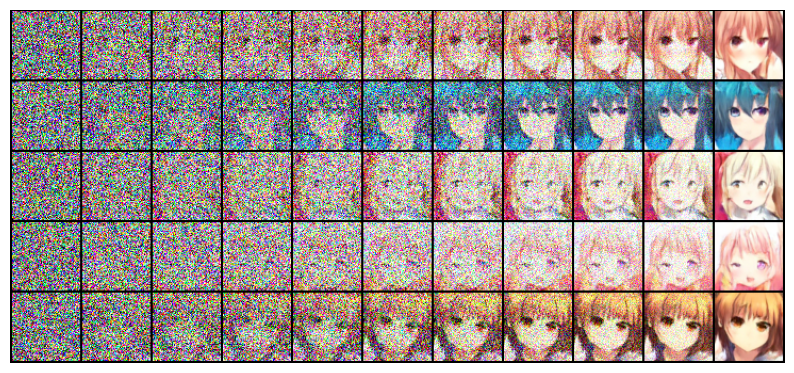

In [17]:
show_imgs =  rearrange(imgs[:,0:1001:100].cpu(), 'b t c w h -> (b t) c w h')
grid_img = torchvision.utils.make_grid(show_imgs, ncol=1, nrow=11)
plt.figure(figsize=(10,10))
plt.imshow(grid_img.permute(1, 2, 0))
plt.axis('off')
plt.show()

## 2. Canonical diffusion model (DDPM) is slow during inference, Denoising Diffusion Implicit Model (DDIM) is at least 10 times faster than DDPM during inference, and preserve the qualities. 

## Please describe the differences of training,  inference process, and the generated images of the two models respectively. Briefly explain why DDIM is faster.

https://zhuanlan.zhihu.com/p/565698027

簡言之，簡化生成的步驟

方法是移除生成時的 noise，這樣就可以跳過，因為一切皆為確定的